<a href="https://colab.research.google.com/github/Tharusha-Sihan/BSP-Paper-Implementation/blob/main/emd_eemd_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb
!pip install EMD-signal
!pip install antropy

from google.colab import drive
drive.mount('/content/drive')

!ls '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.1 MB/s eta 0:00:00
  Created wheel for antropy: filename=antropy-0.1.6-py3-none-any.whl size=16879 sha256=c5603e2e8160c804de669edef5b75ef776595440457a9699d36a572ba4d61286
  Stored in directory: /root/.cache/pip/wheels/98/22/06/e91d7bb213c7133d5e2eb34258623e1e19928d5f05e1ee6812
Successfully built antropy
Mounted at /content/drive
1

In [2]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg

In [3]:
# Function definitions

# Preprocessing

# Mean bias correction
def bias_correction(signal):
    return signal - np.mean(signal)

# moving average filter
def MA_filter(signal, window_size=6):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# High pass filter
def HP_filter(signal, cutoff=1, fs=360, order=6):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='high', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # Apply filter
    return filtered_signal

# Low pass filter
def LP_filter(signal, cutoff=45, fs=360, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # forward backward filtering
    return filtered_signal

# Denoising
def denoise(signal):
    stage1 = bias_correction(signal)
    stage2 = MA_filter(stage1)
    stage3 = HP_filter(stage2)
    stage4 = LP_filter(stage3)
    return stage4

# EMD
def signal_emd(signal, num_imfs_to_keep=5, spline="cubic"):
    # Perform EMD on the signal
    imfs = emd(signal)

    # Select a subset of IMFs (keep the first num_imfs_to_keep)
    imfs_to_keep = imfs[:num_imfs_to_keep]
    return imfs_to_keep

# EEMD
def signal_eemd(signal, num_imfs_to_keep=7, spline="cubic"):
    # Perform EEMD on the signal
    imfs = eemd(signal)

    # Select a subset of IMFs (keep the first num_imfs_to_keep)
    imfs_to_keep = imfs[:num_imfs_to_keep]
    return imfs_to_keep


# Extracting the feature vector from a set of IMFs
def extract_features(IMFs):
    # Combine all features into a feature vector
    feature_vector = []
    for imf in IMFs[:-1]:
        # Calculate Sample Entropy
        sampEn = ant.sample_entropy(imf)

        # Calculate Coefficient of Variation (CV)
        mean_imf = np.mean(imf)
        std_imf = np.std(imf)
        CV = (std_imf / mean_imf) ** 2

        # Perform SVD and extract singular value
        singular_value = svd(imf.reshape(-1, 1), compute_uv=False)[0]

        # Calculate Band Power
        bp_value = np.mean(np.square(imf))

        features = [sampEn, CV, singular_value, bp_value]
        feature_vector = np.concatenate((feature_vector,features))
    return feature_vector


# Extracting features data fram from an input dataframe
def Get_features_df(input_df,decompose = "emd"):
    all_features_df = pd.DataFrame()
    for i in range(input_df.shape[0]):
        X_i = input_df.iloc[i, :-1].to_numpy()
        y_i = input_df.iloc[i,-1]

        if (decompose == "eemd"):
            IMFs = eemd (X_i,max_imf = 7)
        else:
            IMFs = emd(X_i,max_imf = 5)

        features_i = extract_features(IMFs)
        features_i = np.append(features_i,y_i)
        feature_df = pd.DataFrame([features_i])
        all_features_df = pd.concat([all_features_df,feature_df], ignore_index=True)

    return all_features_df

In [6]:
from PyEMD import EMD, EEMD

# Initializing EMD
emd = EMD(spline_kind ="cubic")

# Initializing EEMD
eemd = EEMD()

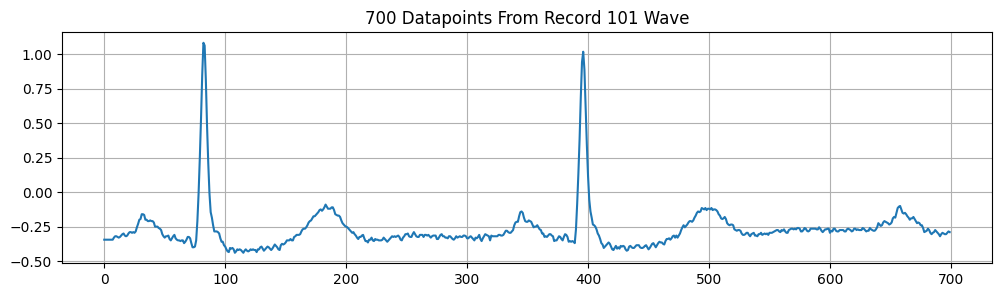

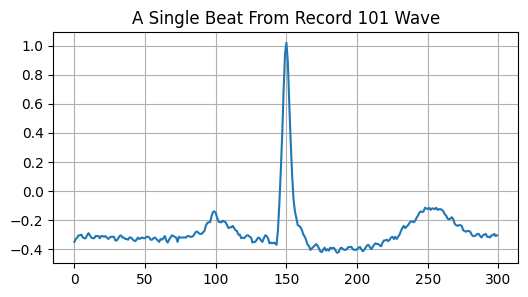


(100018, 300) (100018,)
Class distribution: [75017, 8071, 7255, 2546, 7129]


In [7]:
# Define the path to the dataset directory in your Google Drive
path = '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0/'

# Define Parameters
window_size = 300
maximum_counting = 10000

# Define arrhythmia classes
classes = ['N', 'L', 'R', 'A', 'V']  # Normal, Left Bundle Branch Block, Right Bundle Branch Block, Atrial Premature, Ventricular Premature
n_classes = len(classes)
count_classes = [0] * n_classes

# Initialize lists to store beats and labels
X = list()
y = list()

# Fetch record files from the dataset directory
filenames = next(os.walk(path))[2]
filenames.sort()

# Process each record and annotation
for filename in filenames:
    example_beat_printed = False
    # Only process .dat files (the signal data files)
    if filename.endswith('.dat'):
        record_name = filename.split('.')[0]

        # Read the record (signals) and annotations
        record = wfdb.rdrecord(path + record_name)
        annotation = wfdb.rdann(path + record_name, 'atr')

        signals = record.p_signal[:, 0]  # Taking Lead I for simplicity

        # Process the annotations to extract beats
        for i in range(len(annotation.sample)):
            arrhythmia_type = annotation.symbol[i]

            # Plot an example to the signals
            if i == 1 and record_name == '101':
                # Plot each patient's signal
                plt.figure(figsize=(12, 3))
                plt.title(f"700 Datapoints From Record {record_name} Wave")
                plt.plot(signals[0:700])
                plt.grid(True)
                plt.show()

            if arrhythmia_type in classes:
                arrhythmia_index = classes.index(arrhythmia_type)
                pos = annotation.sample[i]  # Position of the R-peak (sample index)

                # Ensure we don't go out of bounds when extracting the beat
                if window_size//2 <= pos < len(signals) - window_size//2:
                    beat = signals[pos-window_size//2:pos+window_size//2]

                    # Plot an example beat (once)
                    if record_name == '101' and not example_beat_printed:
                        print() # Print an empty space before figure
                        plt.figure(figsize=(6, 3))
                        plt.title(f"A Single Beat From Record {record_name} Wave")
                        plt.plot(beat)
                        plt.grid(True)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)  # 300 point ECG vectors
                    y.append(arrhythmia_index)  # Arrhythmia class labels
                    count_classes[arrhythmia_index] += 1

print() # Print an empty space
print(np.shape(X), np.shape(y))
print("Class distribution:", count_classes)

In [8]:
import pandas as pd

# Creating a data frame
X_df = pd.DataFrame(X)
X_df[len(X[0])] = y
X_df.shape

(100018, 301)

In [9]:
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Resampling the dataset to get to an even distribution
# 2000 test data and 500 training data from each class
n_train = 2000
n_test = 500
n_total = n_train + n_test

test_ratio = n_test/(n_total)

train = pd.DataFrame()
test = pd.DataFrame()

for class_value in range(5):

    # Filter the dataframe for the current class
    df_class = X_df[X_df[300] == class_value]

    # Randomly sample 2500 rows (or all rows if less )
    df_sampled_class = df_class.sample(n=min(n_total, len(df_class)), random_state=42)

    train_class, test_class = train_test_split(df_sampled_class, test_size= test_ratio)

    # Append the sampled rows to the new dataframe
    train = pd.concat([train, train_class])
    test = pd.concat([test, test_class])

# Reset index of the new dataframe
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Display the new dataframe
train.shape, test.shape

((10000, 301), (2500, 301))

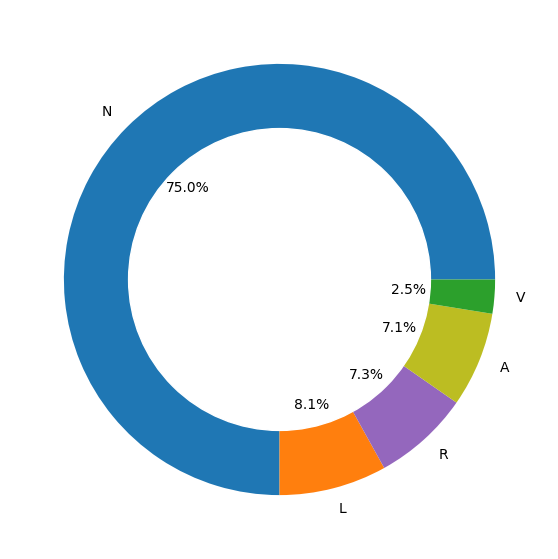

In [10]:
# Distribution of data
per_class = X_df[X_df.shape[1]-1].value_counts()

plt.figure(figsize=(7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [11]:
per_class = train[train.shape[1]-1].value_counts()
print(per_class)

300
0    2000
1    2000
2    2000
3    2000
4    2000
Name: count, dtype: int64


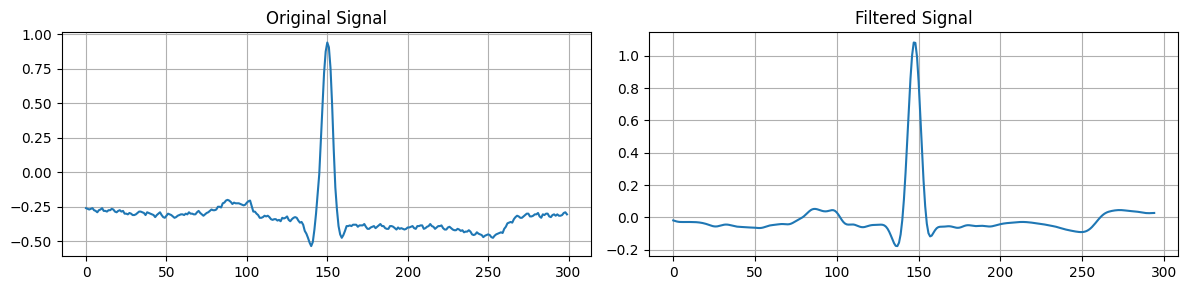

In [12]:
X_filtered = denoise(X[0])

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3))  # 1 rows, 2 columns

# Plot the original signal in the first subplot
axs[0].plot(X[0])
axs[0].set_title('Original Signal')
axs[0].grid(True)

# Plot the filtered signal in the second subplot
axs[1].plot(X_filtered)
axs[1].set_title('Filtered Signal')
axs[1].grid(True)

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

In [13]:
# from PyEMD import EMD, EEMD

# EMD
def signal_emd(signal, num_imfs_to_keep=5, spline="cubic"):

    # Perform EMD on the signal
    imfs = emd(signal)

    # Select a subset of IMFs (keep the first num_imfs_to_keep)
    imfs_to_keep = imfs[:num_imfs_to_keep]

    return imfs_to_keep

# EEMD
def signal_eemd(signal, num_imfs_to_keep=7, spline="cubic"):

    # Perform EMD on the signal
    imfs = eemd(signal)

    # Select a subset of IMFs (keep the first num_imfs_to_keep)
    imfs_to_keep = imfs[:num_imfs_to_keep]

    return imfs_to_keep

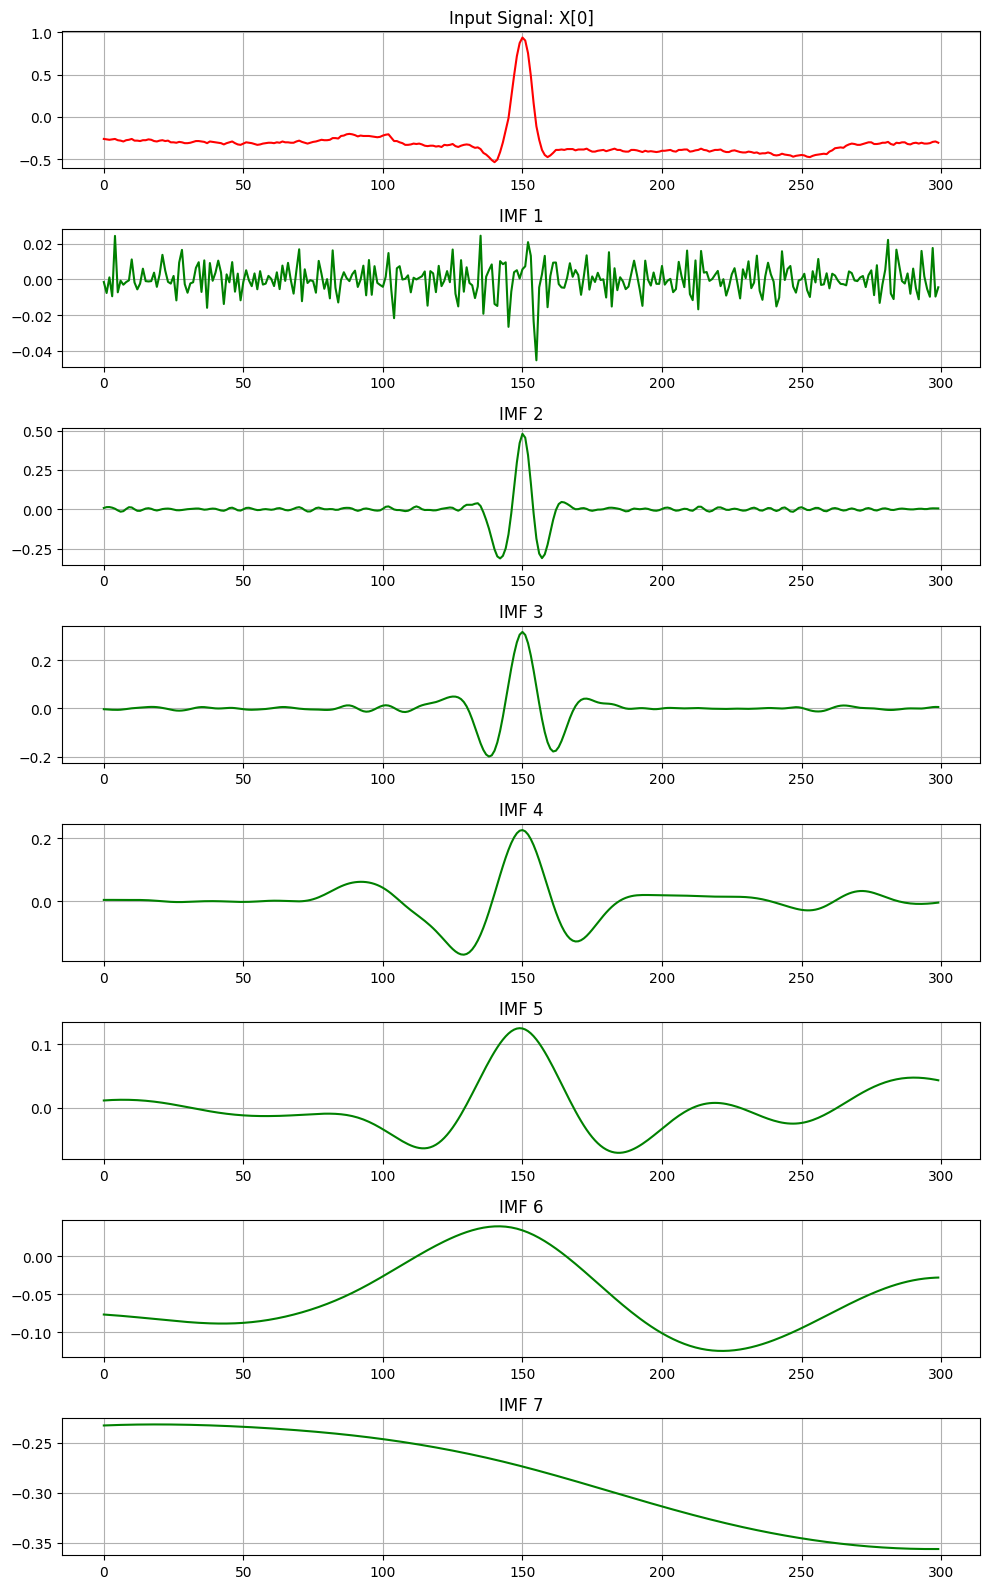

In [14]:
# Execute EEMD on signal
IMFs = signal_eemd(X[0])
N = IMFs.shape[0] + 1  # Number of subplots

plt.figure(figsize=(10, 2*N))  # Adjust the height based on the number of IMFs

# Plot the input signal
plt.subplot(N, 1, 1)
plt.plot(X[0], "r")
plt.title("Input Signal: X[0]")
plt.grid(True)

# Plot each IMF
for n, imf in enumerate(IMFs):
    plt.subplot(N, 1, n + 2)
    plt.plot(imf, "g")
    plt.title(f"IMF {n + 1}")
    plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [15]:
import antropy as ant
from numpy.linalg import svd

# def extract_features(IMFs):
#     # Combine all features into a feature vector
#     feature_vector = []
#     for imf in IMFs:
#         # Calculate Sample Entropy
#         sampEn = ant.sample_entropy(imf)

#         # Calculate Coefficient of Variation (CV)
#         mean_imf = np.mean(imf)
#         std_imf = np.std(imf)
#         CV = (std_imf / mean_imf) ** 2

#         # Perform SVD and extract singular value
#         singular_value = svd(imf.reshape(-1, 1), compute_uv=False)[0]

#         # Calculate Band Power
#         bp_value = np.mean(np.square(imf))

#         features = [sampEn, CV, singular_value, bp_value]
#         feature_vector.append(features)
#         feature_df = pd.DataFrame(feature_vector, columns=['SampEn', 'CV', 'Singular Value', 'Band Power'])

#     return feature_df

# feature_vector = extract_features(IMFs)
# feature_vector

In [16]:
train_features_df = Get_features_df(train)
test_features_df = Get_features_df(test)

print(train_features_df.shape)
print(test_features_df.shape)

(10000, 21)
(2500, 21)


In [17]:
train_features_df.head()

,0,1,2,3,4,...,16,17,18,19,20
0,0.598279,14410.582487,0.630670,0.001326,0.038895,...,0.073977,9.303579,3.424453,0.039090,0.0
1,0.293640,158.048202,1.468536,0.007189,0.105911,...,0.048907,1.875823,2.853220,0.027136,0.0
2,0.436555,1141.912389,0.688478,0.001580,0.103433,...,0.100471,36.439917,2.132630,0.015160,0.0
3,0.011132,1067.447364,1.731907,0.009998,0.066459,...,0.091479,7.185186,4.394210,0.064364,0.0
4,0.084453,1057.136195,2.299762,0.017630,0.162975,...,0.043161,3.011541,0.554891,0.001026,0.0


In [18]:
test_features_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.612400,220.694615,1.085728,0.003929,0.181628,271.465921,1.565547,0.008170,0.131569,10723.908240,...,0.026124,0.253038,802109.086732,3.421802,0.039029,0.081263,2.318042e+02,1.285581,0.005509,0.0
1,0.091969,774.637295,0.794780,0.002106,0.424310,1380.624241,0.624051,0.001298,0.113287,1567.145011,...,0.004596,0.349624,51.871030,1.212752,0.004903,0.087851,6.173117e+01,1.194563,0.004757,0.0
2,0.010483,7543.777904,4.325467,0.062366,0.024990,1390.415175,2.829391,0.026685,0.071975,3.822731,...,0.098742,0.056323,2.252662,4.193229,0.058611,0.050585,1.386996e+01,0.761228,0.001932,0.0
3,0.026173,3797.456309,2.105616,0.014779,0.022445,66762.623674,1.876179,0.011733,0.070489,63.698616,...,0.021739,0.208632,220.307474,4.003188,0.053418,0.131819,2.868638e+09,1.904785,0.012094,0.0
4,0.069120,19539.206841,1.556954,0.008080,0.087029,846.083540,0.977243,0.003183,0.069940,93.107180,...,0.007421,0.173730,11461.421560,1.278224,0.005446,0.096805,8.675367e+01,1.261244,0.005302,0.0
